# Environment Set Up

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from smurfs_dataset import SmurfsDataset
import ipywidgets as widgets
from IPython.display import display

import torch
import torch.utils.data
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from PIL import Image
import torchvision.transforms as transforms
import torch

from tensorboardX import SummaryWriter 

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2 
import urllib.request
import random

from pycocotools.coco import COCO

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import segmentation_models_pytorch.utils.losses as loss_lib

# Loading and Labeling Data

In [3]:
data_path = "/data/smurfs_coco_format/"
json_file_name = "result.json"

num_images = 42
imgs_ids = list(range(num_images))
dataset = SmurfsDataset(data_path, json_file_name, imgs_ids)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [4]:
def update_annot_cat(dataset):
    print("Category Ids:", dataset.categ_dict)
    
    while True:
        ann_id = input("Enter Annotation Id: ")
    
        if not ann_id.isdigit():
            break
            
        cat_id = input("Enter Category Id: ")
    
        if not cat_id.isdigit():
            break
        
        dataset.set_annot_cat_by_id(int(cat_id), int(ann_id))
        dataset.update_json_cat_by_ann_id(int(cat_id), int(ann_id))
        print(f'Annotation ID {ann_id} with new category id {cat_id}')
    
        print("-------------")

### Updating the labeled data

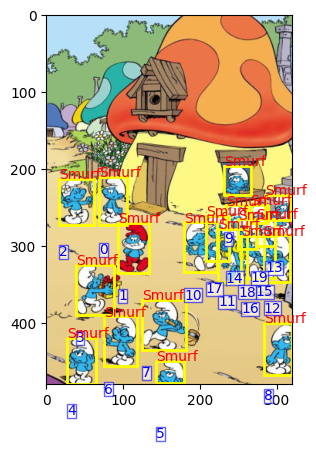

In [5]:
dataset.visualize_annot_by_imgid(0)

In [6]:
if False:
    update_annot_cat(dataset)

# Preprocessing Data

## Train - Test Split

In [127]:
data_path = "/data/smurfs_coco_format/"
json_file_name = "updated_result.json"

num_images = 42
imgs_ids = list(range(num_images))

train_images = int(num_images*0.75)
test_images = num_images - train_images

train_ids = random.sample(imgs_ids,train_images)
test_ids = list(set(imgs_ids) - set(train_ids))


train_dataset = SmurfsDataset(data_path, json_file_name, train_ids, seg_only=False)
test_dataset = SmurfsDataset(data_path, json_file_name, test_ids, seg_only=False)

print("Categories: ", train_dataset.categ_dict)


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Categories:  {0: {'id': 0, 'name': 'Smurf'}, 1: {'id': 1, 'name': 'Papa Smurf'}, 2: {'id': 2, 'name': 'Smurfette'}, 3: {'id': 3, 'name': 'Vanity Smurf'}}


### Visualizing that the annotations labels are well updated

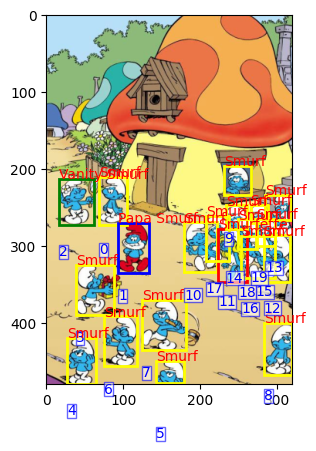

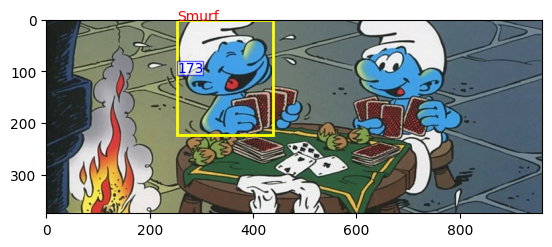

In [128]:
train_dataset.visualize_annot_by_imgid(0)
test_dataset.visualize_annot_by_imgid(10)

### Making sure the images and annotations are being transformed properly

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


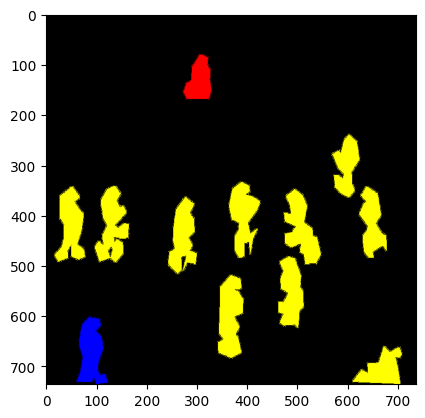

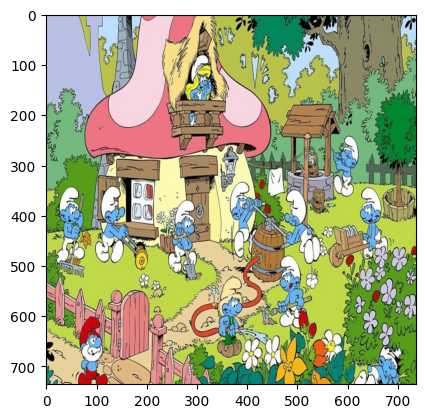

In [130]:
data = train_dataset.__getitem__(2)

mask = data['target']['segmentation'].detach().numpy()

toPIL_transform = transforms.ToPILImage()
img_tensor = data['image'].detach()
img_pil = toPIL_transform(img_tensor)

img = toPIL_transform(data['image_pil'])
# print(img.shape)
rgb_mask = train_dataset.generate_multi_class_mask(mask)

plt.figure()
plt.imshow(rgb_mask)

plt.figure()
plt.imshow(img)


(736, 736, 3)


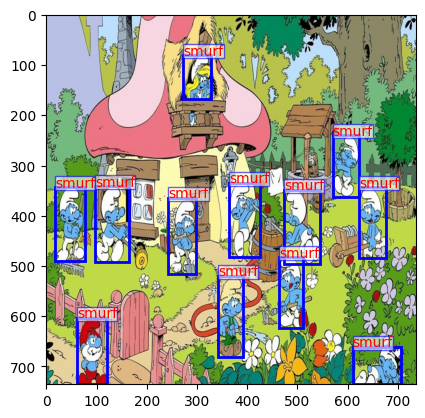

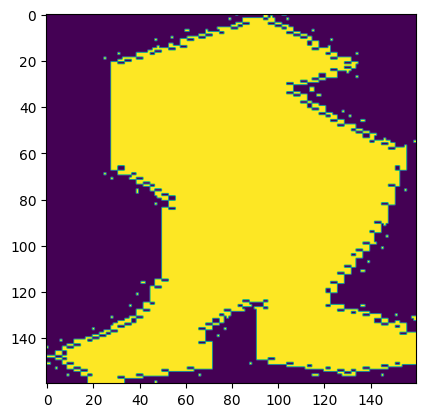

In [133]:
bboxes = data['target']['boxes']
len(bboxes)

plt.figure()
for bbox in bboxes:
    x, y, w, h = [int(b) for b in bbox]
    
    rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='b', facecolor='none')
    
    t_box=plt.text(x, y, "smurf",  color='red', fontsize=10)
    t_box.set_bbox(dict(boxstyle='square, pad=0',facecolor='white', alpha=0.6, edgecolor='blue'))
    plt.gca().add_patch(rect)
plt.imshow(img)         

tm, ti = train_dataset.extract_sub_segment(bboxes, mask, img_pil)

print(rgb_mask.shape)
plt.figure()
plt.imshow(tm[0])

# Training Code

In [10]:
#To make sure the encoder weights do not get updated as it has been training with a large amount of data from imagenet
def freeze_encoder(model):
    for child in model.encoder.children():
        for param in child.parameters():
            param.requires_grad = False

In [11]:
def log_image_tensorboard(writer, img, descr, it):
    writer.add_image(descr, img, it)

In [ ]:
for epoch in range(num_epochs):
    num_plot_imgs = 0
    for batch in dataloader:
        
        inputs = batch['image'].to(device, dtype=torch.float)
        inputs_pil = batch['image_pil'].to(device, dtype=torch.float)
        target_masks = batch['target']['segmentation'].to(device)

In [17]:
#Code to Save the trained model
model_filename = "/models/smurfs_segmentation"
torch.save(model.state_dict(), model_filename)

# Video Validation of Smurfs

### Download video

In [23]:
url_link = "https://radix-senior-hiring-challenge.s3.eu-west-1.amazonaws.com/computer_vision/smurf_video_2.mp4"
video_filename = "/data/smurfs_val_video.mp4"
urllib.request.urlretrieve(url_link, video_filename) 

('/data/smurfs_val_video.mp4', <http.client.HTTPMessage at 0x7f6eb4d33fd0>)

### Loading Trained Model

In [101]:
model_val = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", 
                 in_channels=3, classes=num_classes)

model_val.load_state_dict(torch.load(model_filename))

<All keys matched successfully>

### Read Video

In [82]:
vid = cv2.VideoCapture(video_filename)

In [134]:
# Read the entire file until it is completed 
while(vid.isOpened()): 
  # Capture each frame 
    ret, frame = vid.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_f = Image.fromarray(frame).resize((736,736)).convert('RGB')
    tensor_f = transforms.ToTensor()(pil_f).unsqueeze(0)
    
    segment = model_val(tensor_f)
    segment = nn.functional.softmax(segment, dim=1)
    bin_seg = (segment > 0.95).float()
    rgb_bin = train_dataset.generate_multi_class_mask(bin_seg[0]\
                            .detach().numpy())
    

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0.7006, 0.1687, 0.1051, 0.0256], grad_fn=<SelectBackward0>)


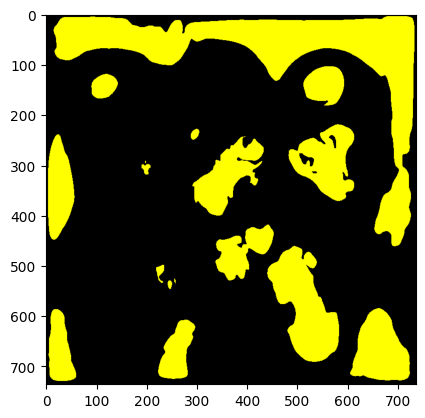

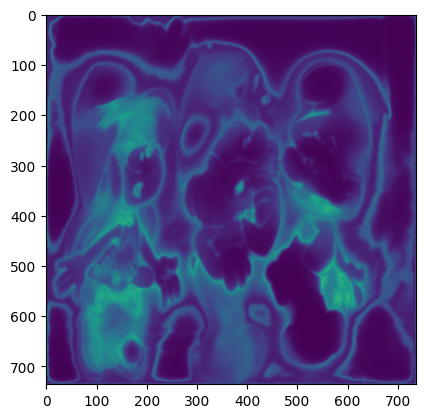

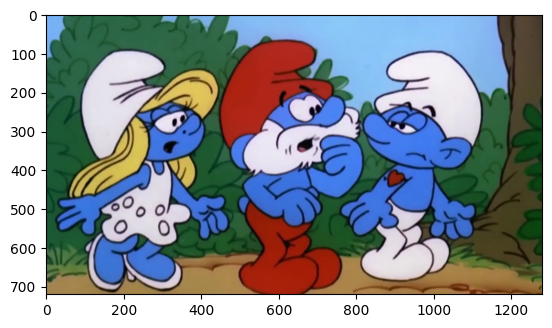

In [138]:
plt.figure()
plt.imshow(rgb_bin)

plt.figure()
plt.imshow(segment[0,3,:,:].detach().numpy())

plt.figure()
plt.imshow(frame)

print(segment[0,:,400,75])